# **Description**

* **There are some compounds in the atmosphere which are majorly emitted as a result of human activities. Some of the compounds are Nitrogen Dioxide, Sulphur Dioxide, Methane, surface Ozone, CO2 and CO, Particulate Matter.**
* **In this Notebook, we will analyse the change in NO2 levels during the covid-19 pandemic restrictions, in and around the geographic area of Pune, India.**


# **About NO2**
* **Nitrogen dioxide (NO2) and nitrogen oxide (NO) together are usually referred to as nitrogen oxides (NOx = NO + NO2). They are important trace gases in the Earth’s atmosphere, present in both the troposphere and the stratosphere.**
* **Nitrogen Dioxide: Nitrogen dioxide enters the atmosphere as a result of anthropogenic activities such as fossil fuel combustion and biomass burning, as well as natural processes including microbiological processes in soils, wildfires and lightning.**
* **During daytime, i.e. in the presence of sunlight, a photochemical cycle involving ozone (O3) converts NO into NO2 (and vice versa) on a timescale of minutes, so that NO2 is a robust measure for concentrations of nitrogen oxides.**


# Resources
* [ https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api-guiattard ]
* [ https://github.com/shakasom/rs-python-tutorials/blob/master/RS_Python.ipynb ]
* [ https://github.com/sarasafavi/remote-sensing-with-python ]


# **Imports**

In [1]:
import ee
import folium 
import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
from scipy import optimize
from folium.plugins import MarkerCluster,HeatMap
%matplotlib inline


**set matplotlib style and pixel density**

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.dpi']=200

# **Authenticate and Inititalize Earth Engine**

In [4]:
#Authenticate EE 
# ee.Authenticate()

In [5]:
#Initialize EE
ee.Initialize()

**Query data for a specified region**

In [6]:
#coordinate of Area

#PUNE Bounding polygon
pune_bb={
0:[73.88178301489967,18.838876790850946],
1:[73.49726153052467,18.736167227010117],
2:[73.53434038794654,18.529258830074227],
3:[73.60025835669654,18.357295234118066],
4:[73.86667681372779,18.31558121975713],
5:[74.06168413794654,18.333832339489497],
6:[74.21549273169654,18.490191319759074],
7:[74.11936236060279,18.69584638649362],
8:[73.88178301489967,18.838876790850946]}


pune_rural={
0:[73.67636171011999,18.69432640862226],
1:[73.50195375113562,18.682618453342783],
2:[73.53216615347937,18.51341351754636],
3:[73.63104310660437,18.394870327434944],
4:[73.85900941519812,18.302323879400006],
5:[74.02929750113562,18.34534459187982],
6:[74.14190736441687,18.488669505528566],
7:[74.00732484488562,18.49127430673293],
8:[73.94278016715124,18.449592738444547],
9:[73.80957093863562,18.424839518466722],
10:[73.72992005972937,18.509506806032565],
11:[73.68872132926062,18.587624070602104],
12:[73.67636171011999,18.69432640862226]
}


pune_urban={
0: [73.7704321446903,18.508204549042645],
1: [73.85694947867468,18.45089544071767],
2: [73.9297339025028,18.503646571553737],
3: [73.9407202306278,18.554428600120815],
4: [73.89883485465124,18.583068212205728],
5: [73.83429017691687,18.61365520937262],
6: [73.77661195426062,18.65269444856425],
7: [73.74914613394812,18.59543383012851],
8: [73.7704321446903,18.508204549042645]
}

#saving the bounds used in the study
study_bounds={
    'pune':pune_bb,
    'pune_urban':pune_urban,
    'pune_rural':pune_rural
}

with open('bounding_polygons.pkl','wb') as f:
    pickle.dump(study_bounds,f)



#bounded coordinates of urban area of Pune
pune_urban_coords=ee.geometry.Geometry.Polygon(list(pune_urban.values()))

#bounded coordinates of some rural parts of Pune
pune_rural_coords=ee.geometry.Geometry.Polygon(list(pune_rural.values()))


#area of interest
aoi=ee.geometry.Geometry.Polygon(list(pune_bb.values()))

#scale in meters
scale=3000

# **Querying Image Collections Object**

In [7]:
# Query data from EE , taking only NO2_column_number_density and images that intersect with our Area of Interest

'''index_description: Total vertical column of NO2 (ratio of the slant column density of NO2 and the total air mass factor)'''


No2=ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2') \
    .select('NO2_column_number_density') \
    .filterBounds(aoi) 



In [8]:
print('Number of Images in collection  are {}'.format(No2.size().getInfo()))

Number of Images in collection  are 16247


**Get info for the specified region**

In [9]:
# sample a few locations for which No2 data is to be queried

#Central Areas of Pune and PCMC
pune_central=No2.getRegion(geometry=pune_urban_coords,
                          scale=scale,
                          ).getInfo()


# Some rural areas of Pune
pune_rural=No2.getRegion(geometry=pune_rural_coords,
                          scale=5000,
                          ).getInfo()


In [10]:
#helper functions

def get_df(img_collection_info,
           bands):
    '''get a dataframe of values for the given Bands'''
    
    
    df = pd.DataFrame(img_collection_info)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *bands]].dropna()

    # Convert the data to numeric values.
    for band in bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    #lat-long of point as location
    df['location']=df.apply(lambda x : (x['latitude'],x['longitude']),axis=1)
    
    
    # Keep the columns of interest.
    df = df[['time','datetime','location',  *bands]]

    return df
    
def mean_value(df,band):
    '''Taking the mean value for a band for each groupby (by date) object for that region,so that we have a mean value of given band for that region'''
    
    
    #mean value for particular instance of time
    mean_val_df=df.groupby('datetime').agg({f'{band}':['mean','max']})
    mean_val_df.reset_index(inplace=True)
    
    #sortby date
    mean_val_df.sort_values(by='datetime',inplace=True)
    
    return mean_val_df
    

# **Visualization**

**Points of Study**

In [11]:
# lets see the points which are sensed in the study

df_urban=get_df(pune_central,
                ['NO2_column_number_density'])

df_rural=get_df(pune_rural,
                ['NO2_column_number_density'])


m1=folium.Map(location=[18.5477,73.8384],
              tiles='Open Street Map',
              zoom_start=10,min_zoom=9)

HeatMap(data=df_urban['location'],
                       radius=10,
                       opacity=.05,
                       name='Urban').add_to(m1)

HeatMap(data=df_rural['location'],
                       radius=10,
                       opacity=.05,
                       name='rural').add_to(m1)

m1.save('Area_of_study_heatmap.html')

print('AREA in Study (URBAN and RURAL)')
m1

AREA in Study (URBAN and RURAL)


In [12]:
print('Number of Data Points in Urban Study {} \n Number of Data Points in Rural Study {}'.format(len(df_urban),len(df_rural)))

Number of Data Points in Urban Study 37345 
 Number of Data Points in Rural Study 57267


In [13]:
print('Number of Unique locations in Urban Study {} \n Number of Unique locations in Rural Study {}'.format(df_urban['location'].nunique(),df_rural['location'].nunique()))

Number of Unique locations in Urban Study 31 
 Number of Unique locations in Rural Study 48


**NO2 Density Datasets (value: mol/m2)**

In [14]:
# Dataset for Urban Pune NO2 density 
urban_no2=mean_value(df_urban,
                     band='NO2_column_number_density')
#saving urban no2
urban_no2.to_csv('pune_urban_no2.csv',index=False)

# Rural NO2 Dataset
rural_no2=mean_value(df_rural,
                    band='NO2_column_number_density')
#saving 
rural_no2.to_csv('pune_rural_no2.csv',index=False)

**Plotting change in NO2 density over time**

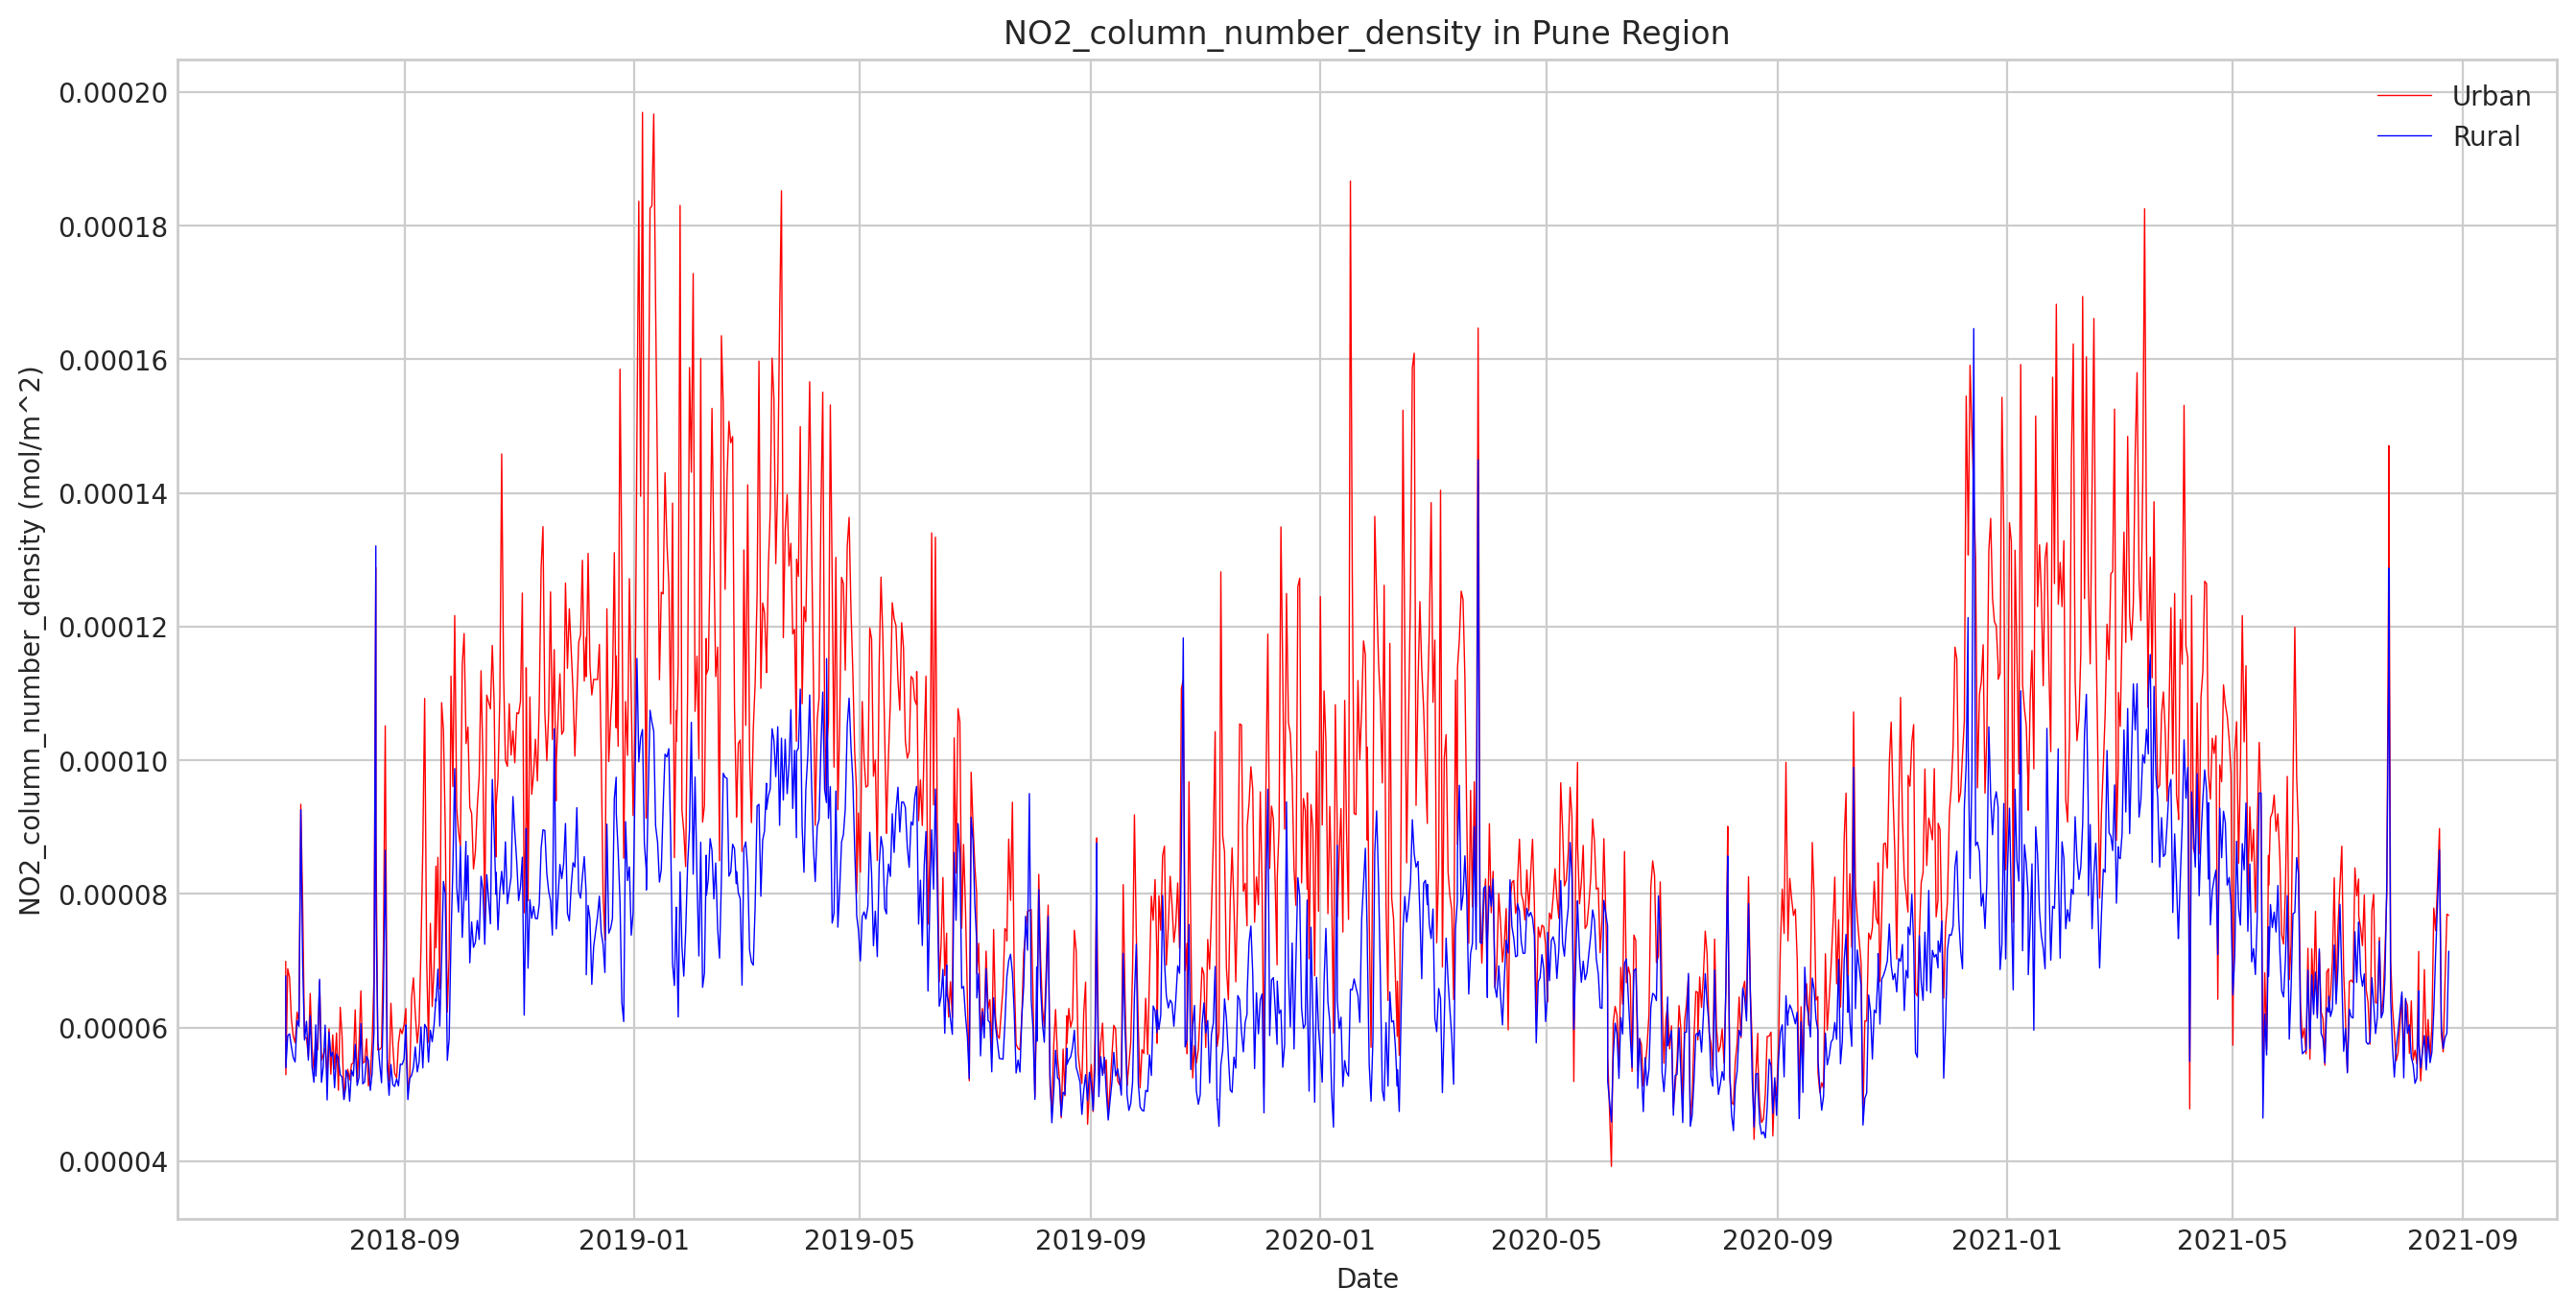

In [15]:
#helper Functions

def plot_all_values(df,
                    df2,
                    band):
    '''Plot all the given values,
    df: Urban Dataset
    df2:rural Dataset'''
    
    fig,ax=plt.subplots(figsize=(16,8))
    
    ax.plot(df.datetime,
            df[band]['mean'],
            color='r',
            lw=0.5,
            label='Urban')

    ax.plot(df2.datetime,
            df2[band]['mean'],
            color='b',
            lw=0.5,
            label='Rural')

    plt.title(f'{band} in Pune Region')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel(f'{band} (mol/m^2)')
    plt.show()
    
    
    
def plot_monthwise(df,
                  df2,
                  band):
    '''plot seasonal trend in concentration of specified band'''
        
    #mean NO2 level for each month 
    urban=df.groupby(df.datetime.dt.month).agg({(f'{band}','mean'):'mean'})
    urban.index.name='Months'
    urban.reset_index(inplace=True)
    
    
    rural=df2.groupby(df.datetime.dt.month).agg({(f'{band}','mean'):'mean'})
    rural.index.name='Months'
    rural.reset_index(inplace=True)
    
    
    
    comb=urban.merge(rural,on='Months',how='inner')
    comb.rename(columns={'NO2_column_number_density_x':f'Urban','NO2_column_number_density_y':f'Rural'},inplace=True)
    comb.set_index('Months',inplace=True)
    comb.plot(figsize=(16,8))
    
    
    plt.title(f'Monthwise mean {band}')
    plt.xlabel('Month of the year')
    plt.ylabel(f'Monthwise Mean {band} (mol/m^2)')
    plt.show()
    
    

plot_all_values(df=urban_no2,
               df2=rural_no2,
               band='NO2_column_number_density')

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


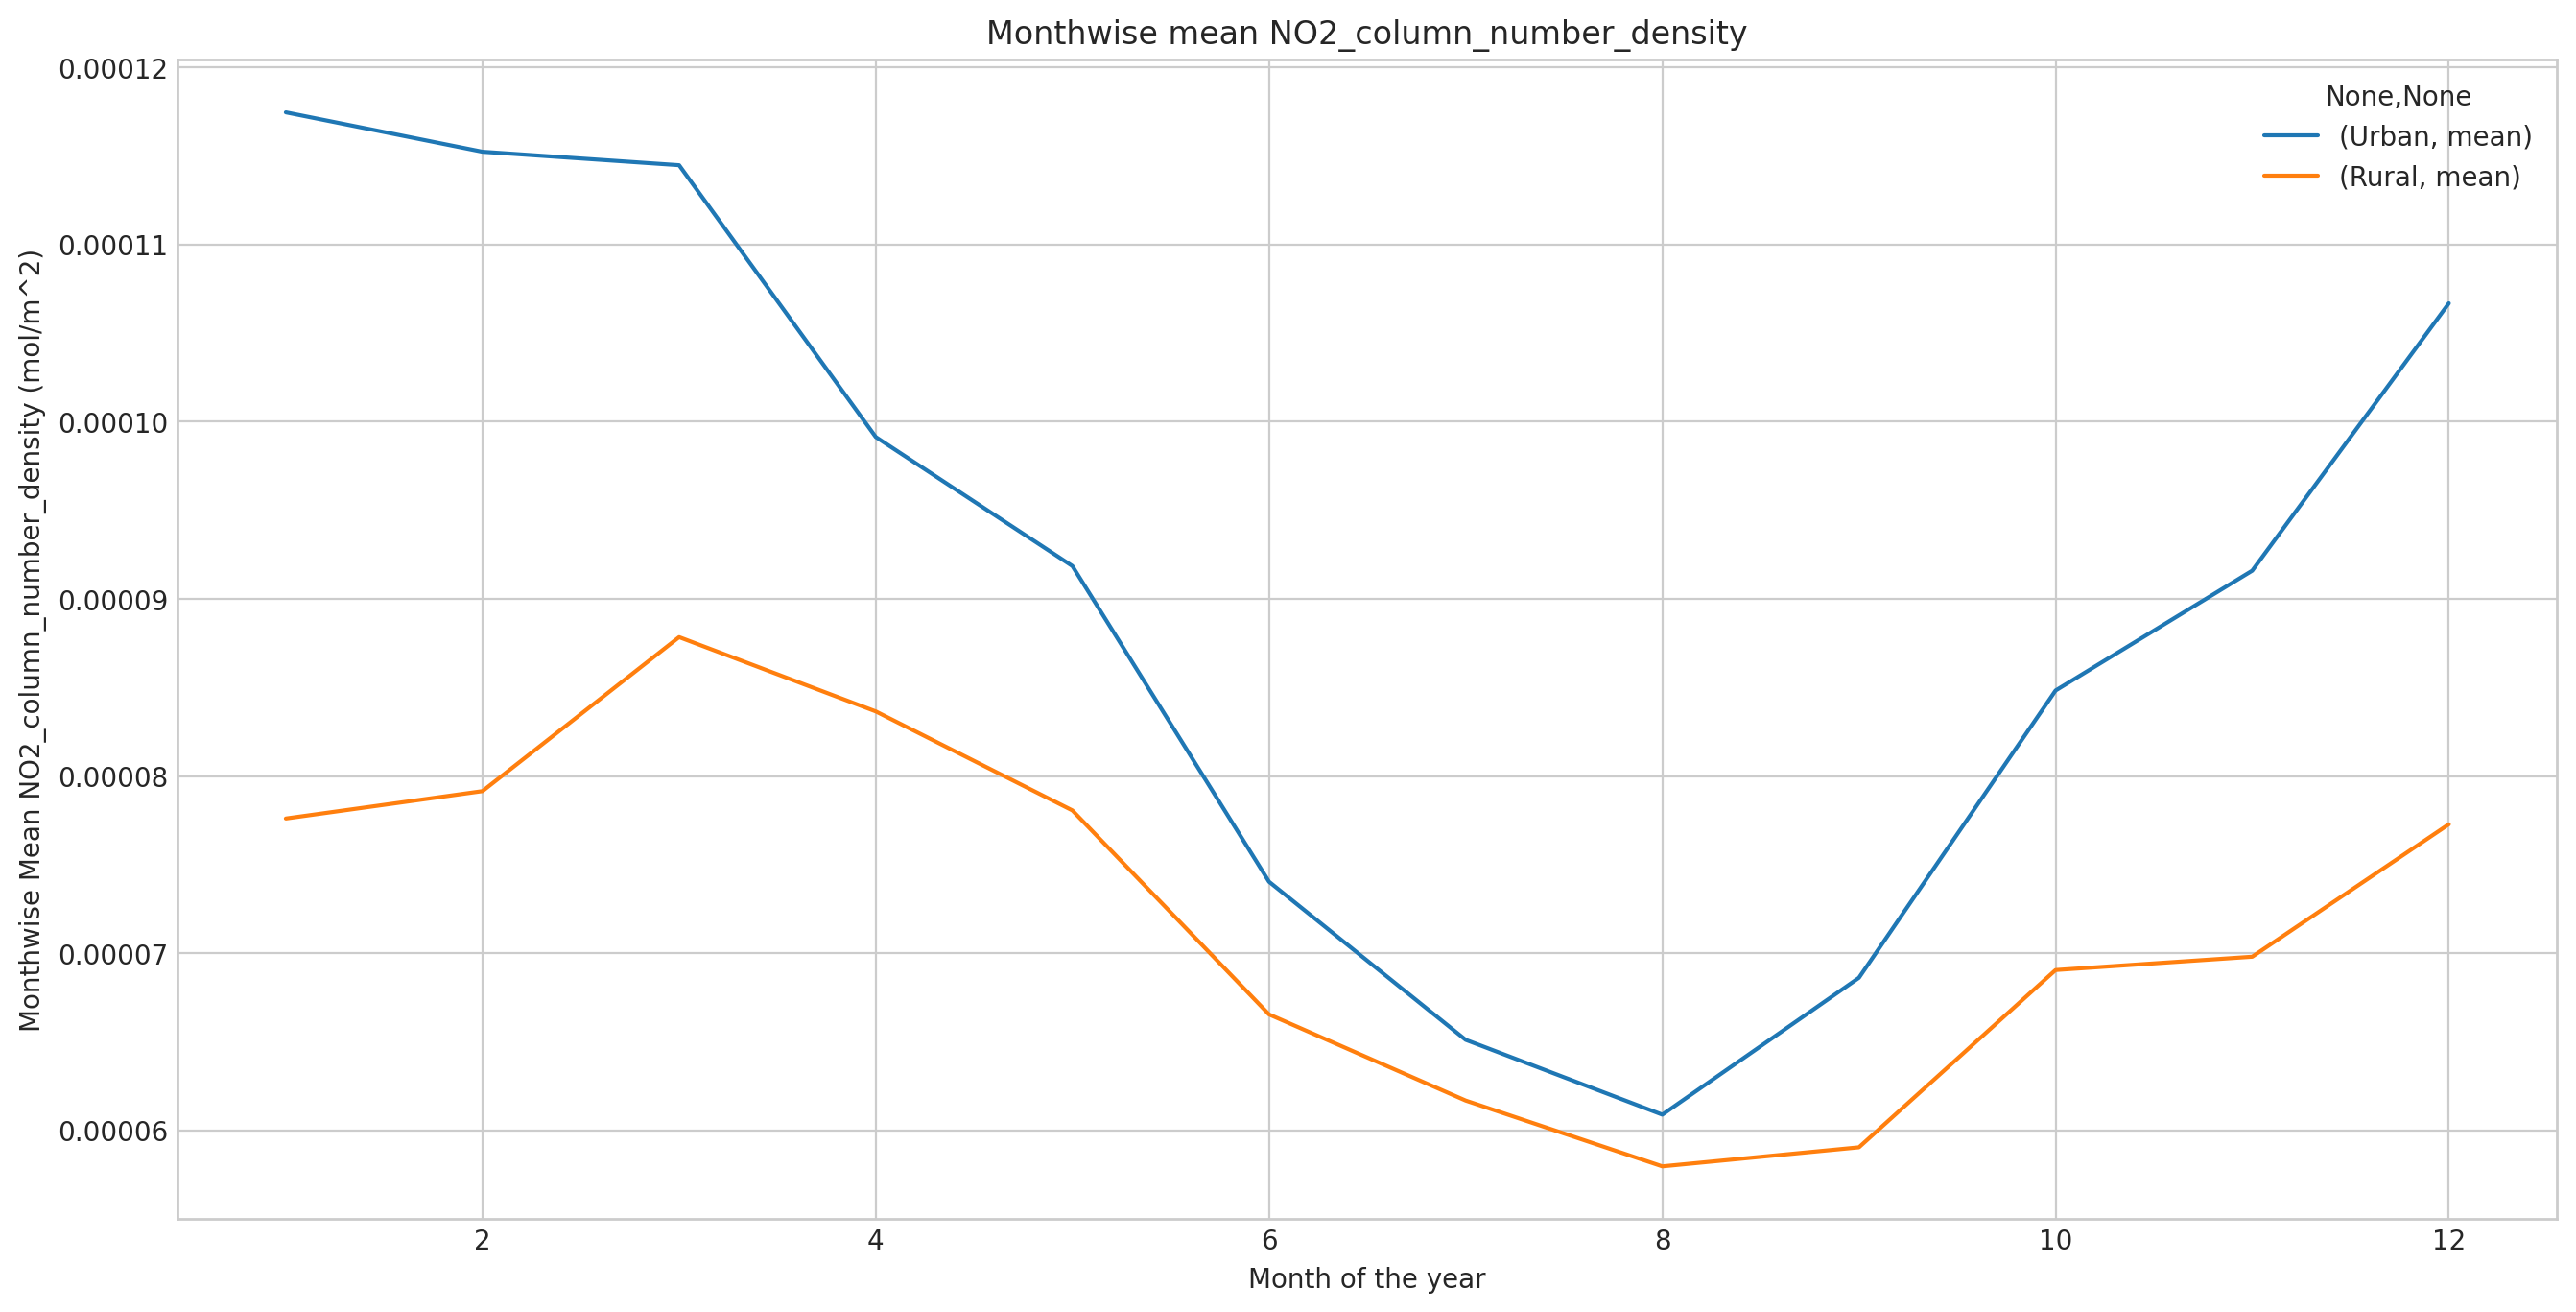

In [16]:
plot_monthwise(df=urban_no2,
               df2=rural_no2,
               band='NO2_column_number_density')

# Effect of Pandemic Restriction on NO2 Concentration

The Concentration of NO2 has a seasonal trend to it. Hence we will compare the changes in concentration around a particular season(i.e summer). Hence taking a period from March to July.

In [17]:
def get_range_df(df,
                date_col,
                start_date,
                end_date):
    '''get a dataframe bounded by start and end date'''
    
    return df[(df[date_col]>start_date)&(df[date_col]<end_date)]



pre_pandemic={
    'start_date':'2019-03-01',
    'end_date'  :'2019-07-01'
}

pandemic={
    'start_date':'2020-03-01',
    'end_date'  :'2020-07-01'
}



In [18]:
#PREPANDEMIC URBAN AND RURAL NO2 DENSITY DATA

#urban
prepandemic_ur=get_range_df(df=urban_no2,
                            date_col='datetime',
                           start_date=pre_pandemic['start_date'],
                           end_date=pre_pandemic['end_date'])

#rural
prepandemic_rur=get_range_df(df=rural_no2,
                            date_col='datetime',
                           start_date=pre_pandemic['start_date'],
                           end_date=pre_pandemic['end_date'])

In [19]:
#PANDEMIC URBAN AND RURAL NO2 DENSITY DATA

#urban
pandemic_ur=get_range_df(df=urban_no2,
                        date_col='datetime',
                        start_date=pandemic['start_date'],
                        end_date = pandemic['end_date'])

#rural

pandemic_rur=get_range_df(df=rural_no2,
                         date_col='datetime',
                         start_date=pandemic['start_date'],
                         end_date=pandemic['end_date'])

In [20]:
def plot_comparison_plots(df,
                          df2,
                          band,
                          Title):
    '''PLOT COMPARISON PLOTS for Before and during Pandemic
    df: NO2 levels during pre Pandemic study period
    df2:NO2 During Pandemic study period
    '''
    fig,ax=plt.subplots(2,1,figsize=(16,8))
    print(f'{Title}')
    
    
    ax[0].plot(df.datetime,
            df[band]['mean'],
            color='r',
            lw=2)
    ax[0].set_title('Before Covid-19')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel(f'{band} (mol/m^2)')
    
    

    ax[1].plot(df2.datetime,
            df2[band]['mean'],
            color='g',
            lw=2)
    ax[1].set_title('During Covid-19')
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel(f'{band} (mol/m^2)')
    
    plt.tight_layout()
    
    #saving image
    fig.savefig(f'{Title}.jpg')
    plt.show()
    

NO2 Concentration over Urban Pune


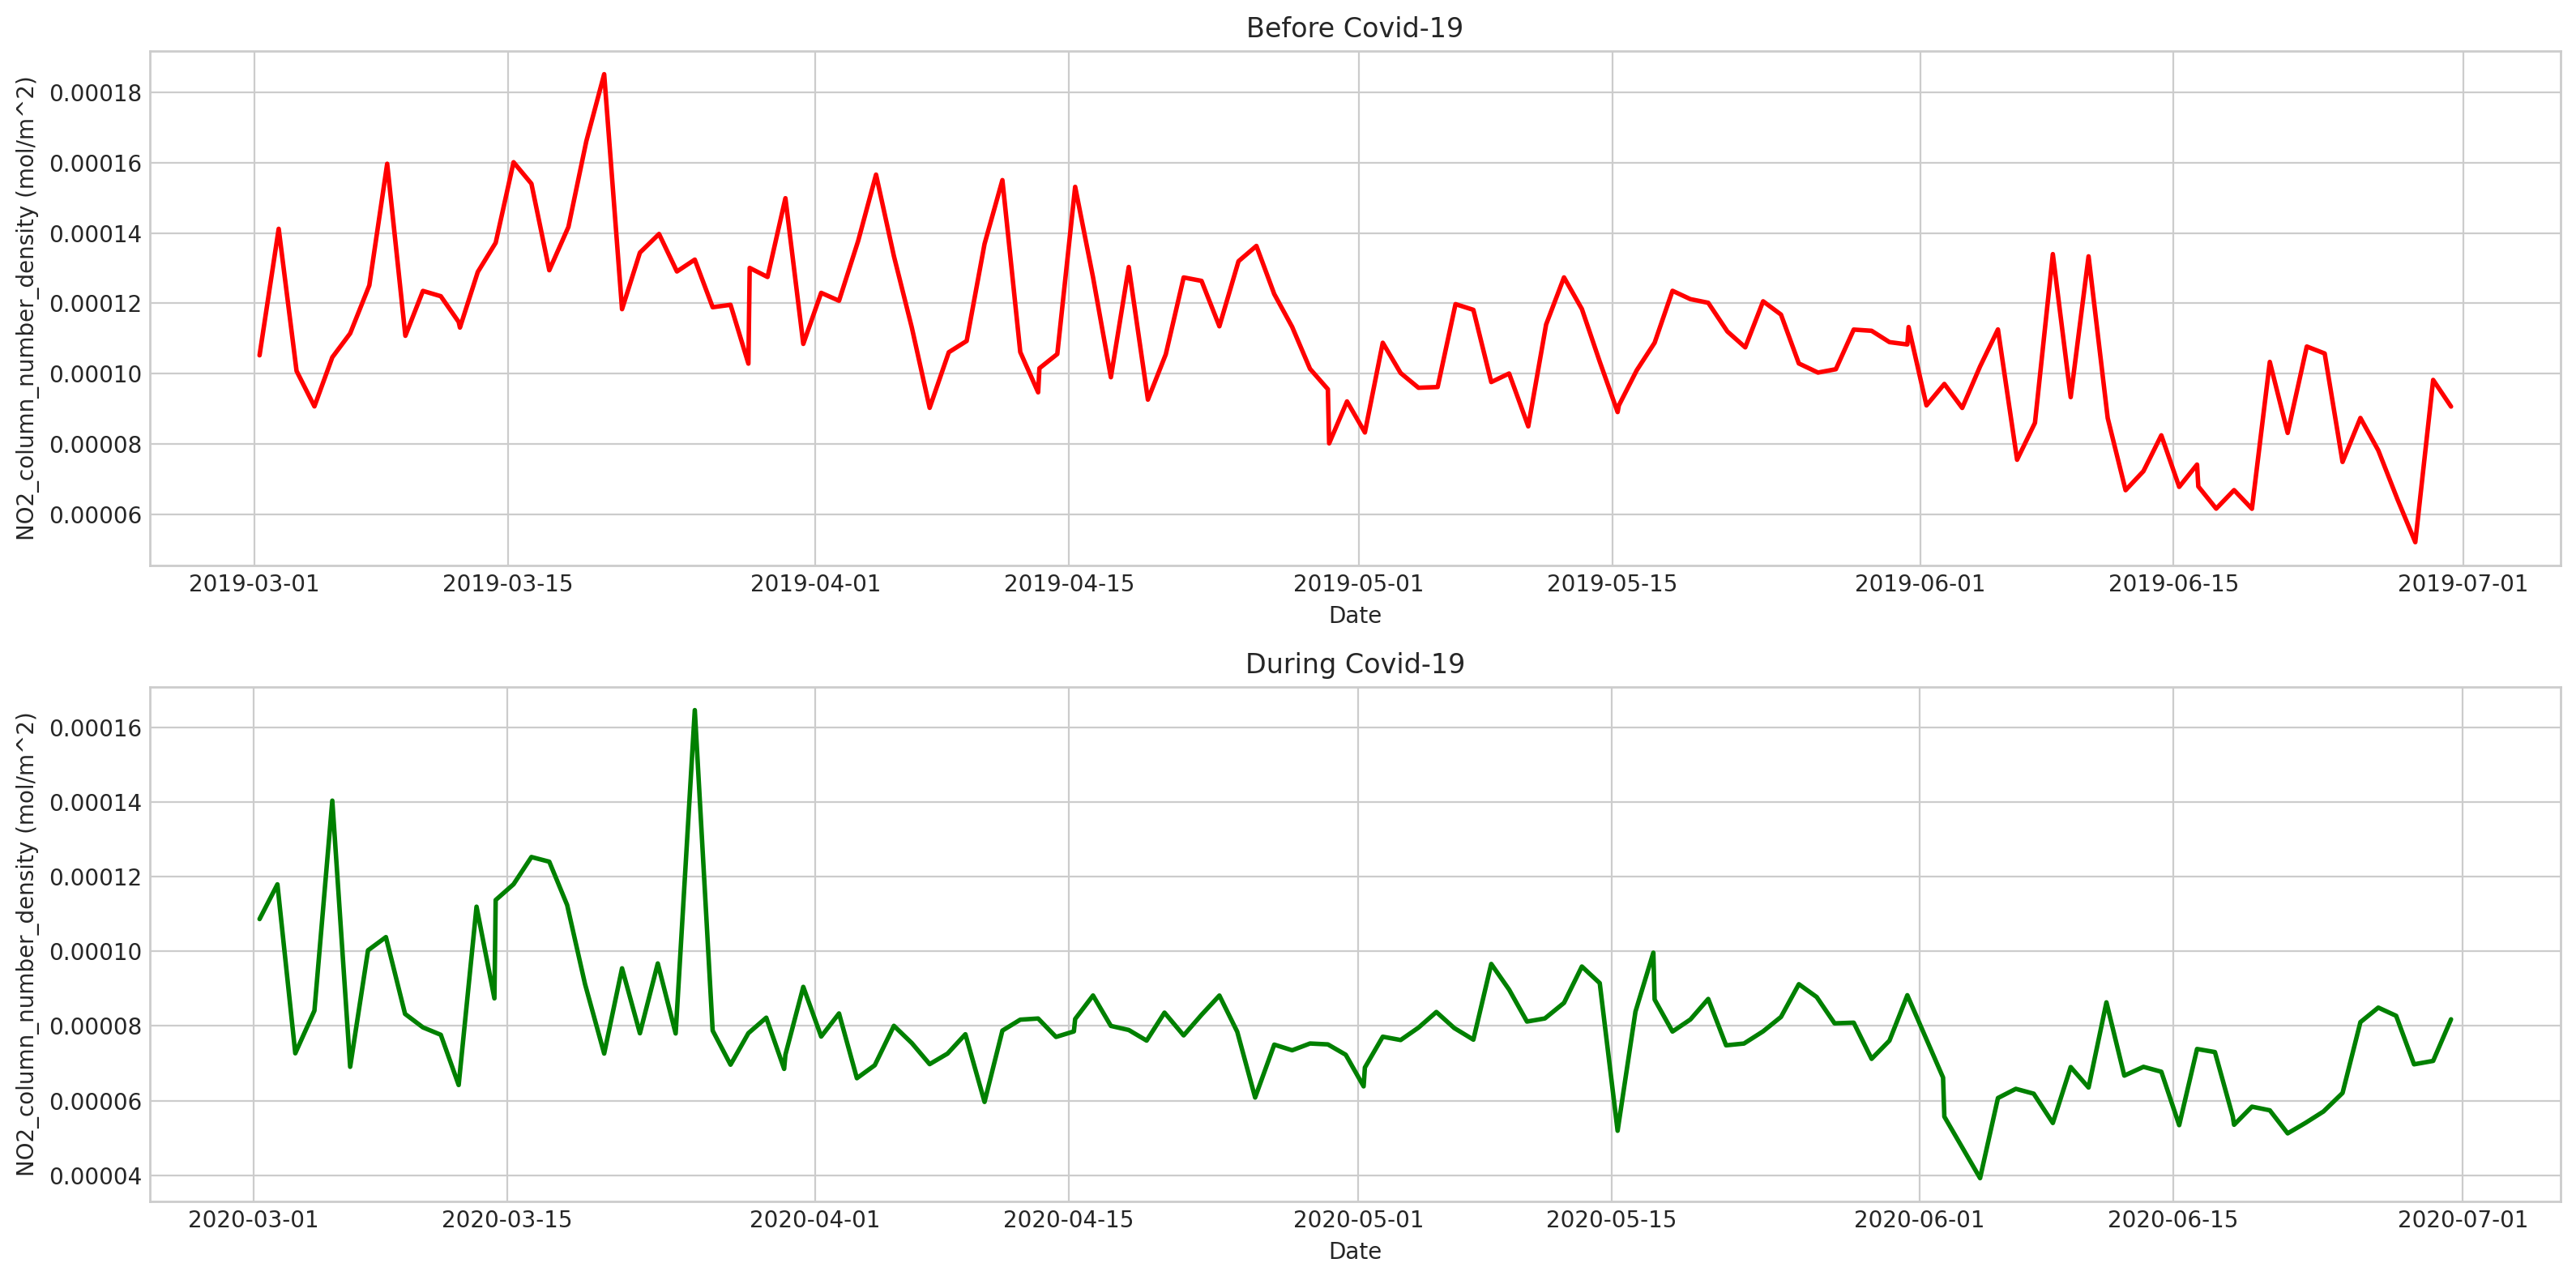

In [21]:
# CHange in NO2 over Urban areas
plot_comparison_plots(df=prepandemic_ur,
                     df2=pandemic_ur,
                     band='NO2_column_number_density',
                     Title='NO2 Concentration over Urban Pune')

NO2 Concentration over Rural Pune


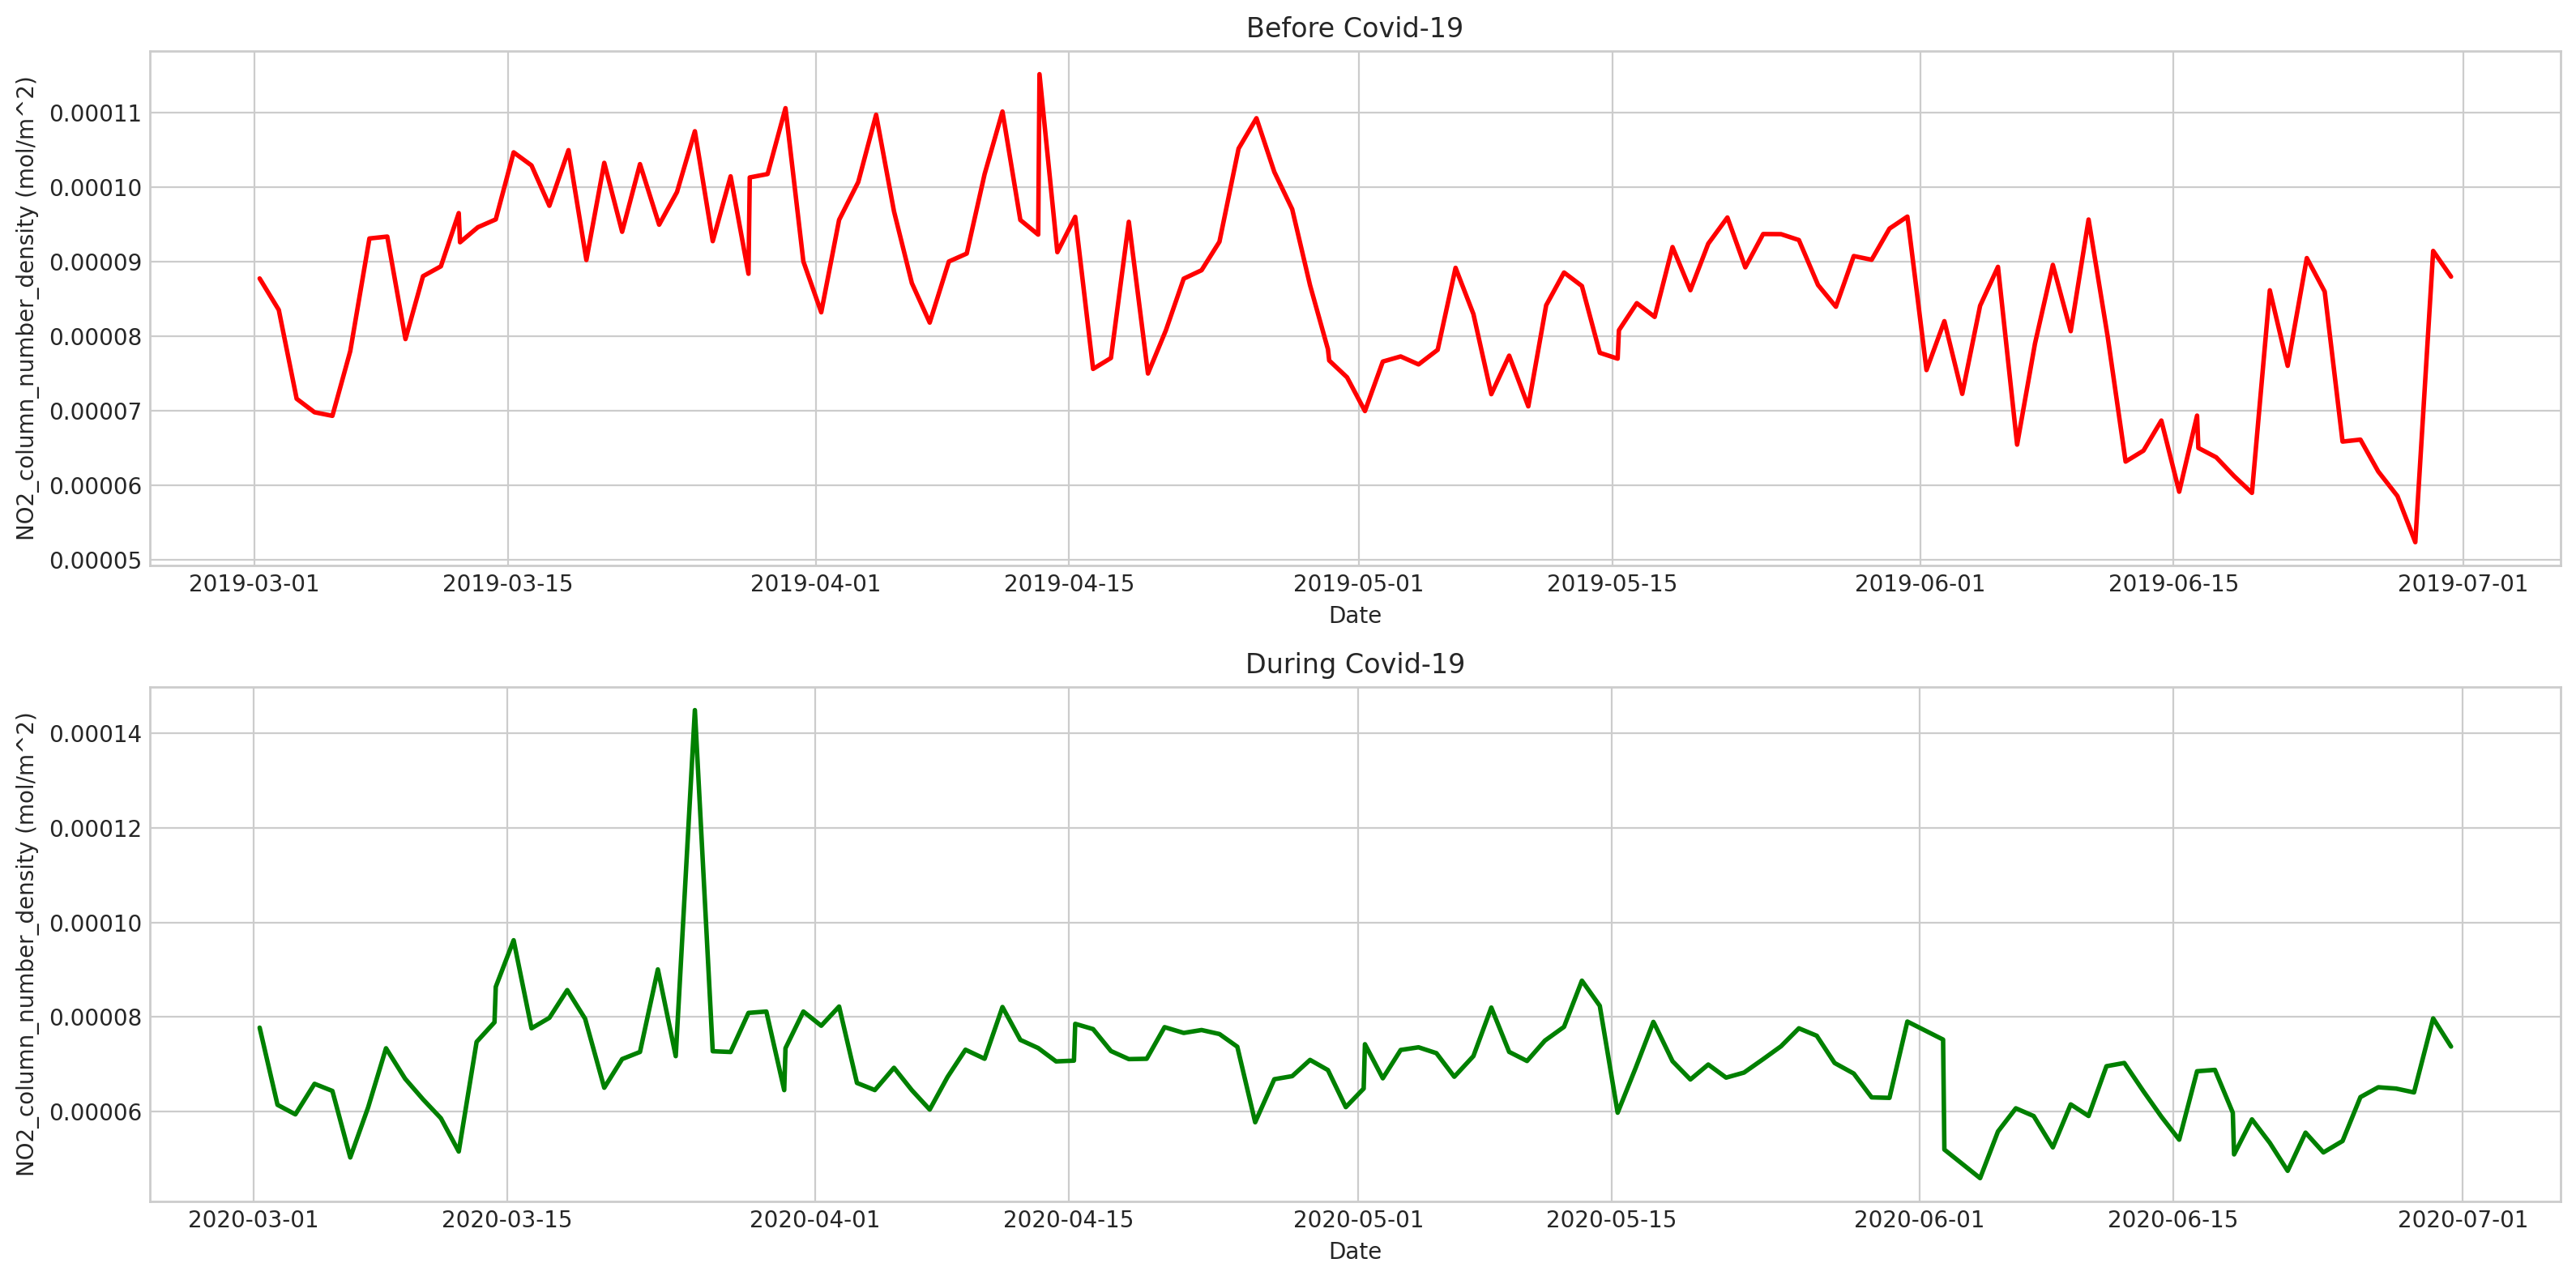

In [22]:
# CHange in NO2 over Rural areas
plot_comparison_plots(df=prepandemic_rur,
                     df2=pandemic_rur,
                     band='NO2_column_number_density',
                     Title='NO2 Concentration over Rural Pune')

**There Definitely has been a reduction in NO2 levels both in Urban and Rural parts of Pune over the time of the pandemic lockdown restrictions, which is clearly visible in the plots above**

In [23]:
# Approximate percent drop in NO2 levels
def percent_change(df,df2,band):
    mean_pre   = df[f'{band}']['mean'].mean()
    mean_during= df2[f'{band}']['mean'].mean()
        
    diff=mean_pre-mean_during
    percent_change=(diff/mean_pre)*100
    
    return percent_change


print('Mean % drop in Urban NO2 level during pandemic restrictions {}'.format(percent_change(df=prepandemic_ur,
                                                                                             df2=pandemic_ur,
                                                                                            band='NO2_column_number_density')))

Mean % drop in Urban NO2 level during pandemic restrictions 27.54998440599629


In [24]:
print('Mean % drop in Rural NO2 level during pandemic restrictions {}'.format(percent_change(df=prepandemic_rur,
                                                                                             df2=pandemic_rur,
                                                                                            band='NO2_column_number_density')))

Mean % drop in Rural NO2 level during pandemic restrictions 18.969293125793357


# **Visualizing change of mean value of NO2 over study period**

In [25]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [26]:

#visualization parameters
viz_param={
    'min': 0.00001, 'max': 0.0002,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}


**PrePandemic (April 2019 to June 2019)**

In [27]:
M2=folium.Map(location=[18.5477,73.8384],
              tiles='Open Street Map',
              zoom_start=10,min_zoom=9)


#adding NO2 density layer
M2.add_ee_layer(ee_image_object=ee.Image(No2.filterDate(pre_pandemic['start_date'],pre_pandemic['end_date']).mean()).clip(aoi),
               vis_params=viz_param,
               name='NO2 Density (April-June 2019)')
print('April 2019 to June 2019')

#add tile control
M2.add_child(folium.LayerControl())
M2.save('Prepandemic_NO2.html')

M2

April 2019 to June 2019


**During Pandemic (April 2020 to June 2020)**

In [28]:
M3=folium.Map(location=[18.5477,73.8384],
              tiles='Open Street Map',
              zoom_start=10,min_zoom=9)

#adding NO2 density layer
M3.add_ee_layer(ee_image_object=ee.Image(No2.filterDate(pandemic['start_date'],pandemic['end_date']).mean()).clip(aoi),
               vis_params=viz_param,
               name='NO2 Density (April-June 2020)')
print('April 2020 to June 2020')

#add tile control
M3.add_child(folium.LayerControl())
#saving map
M3.save('pandemic_NO2.html')

M3

April 2020 to June 2020
